This is needed to reload modules without restarting the kernel

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Line above avoids running on GPU

In [2]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [3]:
import os
os.sys.path.append('../../')

# Categorical Embedding

Categorical embedding for neural network reweighting

In [4]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.1.0'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import  BatchNormalization


In [35]:
import shap

**MDR_VEC 2Buckets Dataset**

In [12]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/data_two_buckets_16.root

-rw-r--r-- 1 lborgna users 453M Feb 23 23:20 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_two_buckets_16.root


In [13]:
f = uproot.open('/mnt/storage/lborgna/NNT/MDR_VEC/data/data_two_buckets_16.root')

In [14]:
f.keys()

[b'control;1', b'validation;1', b'sig;1']

In [15]:
df_cr = f['control'].pandas.df()

In [16]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

Using TensorFlow backend.


In [17]:
df_cr.head()

run_number  event_number  pass_vbf_sel  mc_sf  trig_sf  jet_trig_sfs  \
entry                                                                         
0          297730     170256695         False    1.0      1.0           1.0   
1          297730     177710039         False    1.0      1.0           1.0   
2          297730     178446933         False    1.0      1.0           1.0   
3          297730     181744339         False    1.0      1.0           1.0   
4          297730     184086871         False    1.0      1.0           1.0   

       truth_mhh  ntag  njets  kinematic_region  ...  vbf_pTvecsum   2b1j  \
entry                                            ...                        
0            0.0     2      5                 2  ...           0.0   True   
1            0.0     2      4                 2  ...           0.0  False   
2            0.0     2      4                 2  ...           0.0  False   
3            0.0     2      4                 2  ...           0.0  False   
4            0.0     2      4                 2  ...           0.0  False   

       2b2j  BKT_passed  BKT1_trigger  BKT2_trigger  BKT1_off  BKT2_off  \
entry                                                                     
0      True           1          True          True      True      True   
1      True           2         False          True     False      True   
2      True           2         False          True     False      True   
3      True           2         False          True     False      True   
4      True           2         False          True     False      True   

       BKT1_prev  BKT2_prev  
entry                        
0           True      False  
1           True       True  
2           True       True  
3           True       True  
4           True       True  

[5 rows x 104 columns]

**Prepare the dataset by adding all of the additional features and taking the log of them**

In [25]:
features_to_rw = nominal()

In [31]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [28]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [ ]:
features_to_rw

In [30]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

KeyError: 'X_wt'

**remove stuff we don't care about (not 2b or 4b)**

In [94]:
df_cr = df_cr.loc[(df_cr['ntag']==2) | (df_cr['ntag']>=4)]

In [95]:
df_cr.reset_index(drop=True, inplace = True)

**Create labels**

In [96]:
df_cr['label'] =  1

In [97]:
df_cr.loc[df_cr['ntag']>=4,'label'] = 0

In [100]:
df_cr['label'].value_counts()

1    1738549
0      29775
Name: label, dtype: int64

In [101]:
scaler = StandardScaler()

**Features to use**

In [103]:
rw_col = features_to_rw['rw_cols_log']

In [110]:
rw_col

['pT_2_log',
 'pT_4_log',
 'eta_i',
 'dRjj_1_log',
 'dRjj_2_log',
 'njets',
 'pt_hh_log',
 'X_wt_log',
 'dR_hh',
 'dPhi_h1',
 'dPhi_h2']

**Numerical Features**

In [111]:
rw_num = rw_col[0:5] + rw_col[6:]

**Categorical or discrete Features (for embedding)**

In [112]:
rw_cat = rw_col[5]

In [114]:
df_train, df_test = train_test_split(df_cr, test_size=0.2)

In [115]:
df_train.shape, df_test.shape

((1414659, 85), (353665, 85))

In [173]:
X_train = scaler.fit_transform(df_train[rw_num])
Y_train = df_train['label'].astype('float32').values #float32 conversion to keep tensorflow 2 happy

In [210]:
X_test = scaler.transform(df_test[rw_num])
Y_test = df_test['label'].astype('float32').values 

**Creating the model**

In [212]:
n_unique_values = df_cr['njets'].nunique()
input_cat_data = tf.keras.layers.Input(shape=(n_unique_values,), dtype='int32')
input_num_data = tf.keras.layers.Input(shape=(X_train.shape[1],))

In [213]:
embedding_size = int(min(np.ceil(n_unique_values/2), 50))

In [21]:
emb = tf.keras.layers.Embedding(input_dim = n_unique_values, output_dim=embedding_size)(input_cat_data)
flatten = tf.keras.layers.Flatten()(emb)
conc = tf.keras.layers.Concatenate()([flatten, input_num_data])
dense1 = tf.keras.layers.Dense(50, activation = 'relu')(conc)
dense2 = tf.keras.layers.Dense(50, activation = 'relu')(dense1)
dense3 = tf.keras.layers.Dense(50, activation = 'relu')(dense2)
output = tf.keras.layers.Dense(1, activation = 'linear')(dense3)
model = tf.keras.Model(inputs=[input_cat_data, input_num_data], outputs=output)

NameError: name 'n_unique_values' is not defined

In [215]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 8, 4)         32          input_21[0][0]                   
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 32)           0           embedding_7[0][0]                
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 10)]         0                                            
____________________________________________________________________________________________

In [216]:
import tensorflow.keras.backend as K

In [217]:
def louppe_loss_tf2(y_true, y_pred):
    return (y_true * (K.sqrt(K.exp(y_pred))) + (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [218]:
model.compile(loss=louppe_loss_tf2, metrics = ['accuracy'], optimizer='adam')

In [223]:
from tensorflow.keras.utils import to_categorical

**njets (categorical feature) needs to be one-hot-encoded**

In [224]:
njets_encoded = to_categorical(df_train['njets'].values-4, num_classes=n_unique_values)

In [226]:
njets_encoded_test = to_categorical(df_test['njets'].values - 4, num_classes=n_unique_values)

**TRAIN**

In [227]:
history = model.fit([njets_encoded, X_train], Y_train,
                    callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10, verbose=True),
                            ModelCheckpoint('model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                            epochs=500,
                            batch_size=8192,
                            validation_data=([njets_encoded_test, X_test], Y_test),
                   )

Train on 1414659 samples, validate on 353665 samples
Epoch 1/500
1384448/1414659 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.0170
Epoch 00001: val_loss improved from inf to 0.23878, saving model to model.h5
1414659/1414659 [==============================] - 2s 1us/sample - loss: 0.3180 - accuracy: 0.0170 - val_loss: 0.2388 - val_accuracy: 0.0164
Epoch 2/500
1384448/1414659 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.0169
Epoch 00002: val_loss improved from 0.23878 to 0.23121, saving model to model.h5
1414659/1414659 [==============================] - 1s 1us/sample - loss: 0.2377 - accuracy: 0.0170 - val_loss: 0.2312 - val_accuracy: 0.0164
Epoch 3/500
1392640/1414659 [============================>.] - ETA: 0s - loss: 0.2333 - accuracy: 0.0169
Epoch 00003: val_loss improved from 0.23121 to 0.22884, saving model to model.h5
1414659/1414659 [==============================] - 1s 1us/sample - loss: 0.2333 - accuracy: 0.0170 - val_loss: 

In [228]:
X_all = scaler.transform(df_cr[rw_num].values)

In [229]:
njets_encoded_all = to_categorical(df_cr['njets']-4, num_classes= n_unique_values)

In [230]:
pred = np.exp(model.predict([njets_encoded_all, X_all]))[:,0]

In [231]:
df_cr['weights'] = pred

In [232]:
mask4b=df_cr['ntag']>=4
mask2b=df_cr['ntag']==2

In [233]:
norm = df_cr[mask4b].shape[0] / df_cr.loc[mask2b, 'weights'].sum()

In [234]:
norm

0.9184755359370543

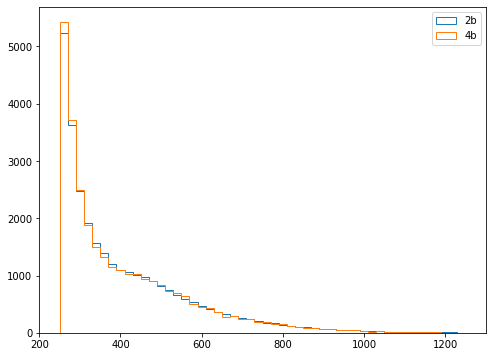

In [235]:
f, ax = plt.subplots(figsize=(8,6))
h2b, be, _ = plt.hist(
    df_cr.loc[mask2b, "m_hh_cor"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm*df_cr.loc[mask2b, "weights"].values,
    label="2b",
)
h4b, _, _ = plt.hist(
    df_cr.loc[mask4b, "m_hh_cor"].values, bins=be, histtype="step", label="4b"
)
plt.legend()

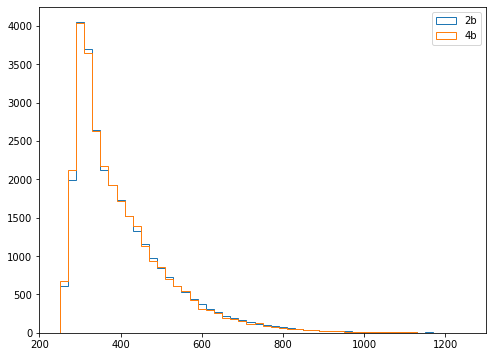

In [236]:
f, ax = plt.subplots(figsize=(8,6))
h2b, be, _ = plt.hist(
    df_cr.loc[mask2b, "m_hh"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm*df_cr.loc[mask2b, "weights"].values,
    label="2b",
)
h4b, _, _ = plt.hist(
    df_cr.loc[mask4b, "m_hh"].values, bins=be, histtype="step", label="4b"
)
plt.legend()

**So its basically done something...**

In [32]:
df_cr['ntag'].value_counts()

2    1056359
4       9335
3       9063
5        205
6          3
7          1
Name: ntag, dtype: int64